<a href="https://colab.research.google.com/github/ymuto0302/RW2025/blob/main/FaceGeneration_DCGAN_CelebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RW2025 での利用を前提として作成

# 顔画像生成GAN（DCGAN）実装 - CelebAデータセット用

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

# GPU/CPUの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用デバイス: {device}")

使用デバイス: cuda


## ハイパーパラメータ

In [ ]:
# ハイパーパラメータ
image_size = 64      # 画像サイズ（64x64）
nc = 3              # カラーチャンネル数（RGB）
nz = 100            # ノイズベクトルの次元
ngf = 64            # Generator のフィルタ数
ndf = 64            # Discriminator のフィルタ数
batch_size = 128    # バッチサイズ
lr = 0.0002         # 学習率
beta1 = 0.5         # Adam最適化器のパラメータ

## CelebAデータセットのダウンロード

CelebAデータセットのダウンロード・・・サーバが混み合っているのか，失敗することがある

CelebA (Large-scale CelebFaces Attributes) データセット:
UTKFace (Large Scale Face Dataset) は顔画像のデータセット

- 202,599 の顔画像
- 10,177 人分
- 5 landmarks (5 ランドマーク), 40属性

http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

In [3]:
# データ前処理の設定
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # -1 to 1に正規化
])

# CelebAデータセットの読み込み
dataset = torchvision.datasets.CelebA(
    root='./data',
    split='train',
    download=True,
    transform=transform
)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

CelebAデータセットを準備中...


# (参考) 実画像の表示


1. データセットの実画像を確認:


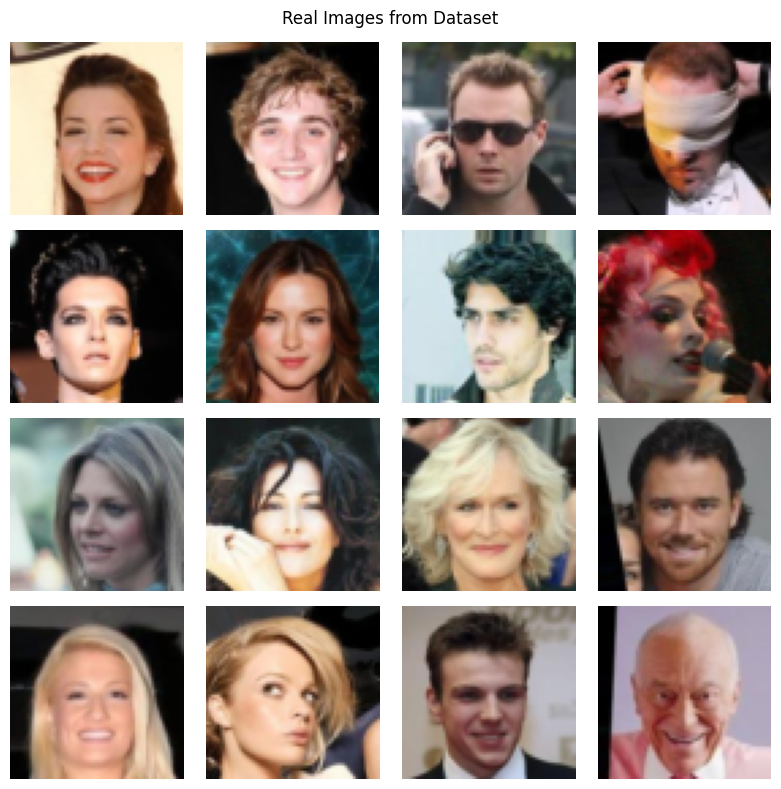

In [5]:
# 実画像の表示
def show_real_images(dataloader, num_images=16):
    real_batch = next(iter(dataloader))
    real_images = real_batch[0][:num_images]

    # -1 to 1の範囲を0 to 1に変換
    real_images = (real_images + 1) / 2

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        img = real_images[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle('Real Images from Dataset')
    plt.tight_layout()
    plt.show()

# 実画像の確認
show_real_images(dataloader)

In [6]:
# ウェイトの初期化関数
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator（生成器）の定義
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # 入力: nz x 1 x 1
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # サイズ: (ngf*8) x 4 x 4

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # サイズ: (ngf*4) x 8 x 8

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # サイズ: (ngf*2) x 16 x 16

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # サイズ: (ngf) x 32 x 32

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 出力サイズ: (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# Discriminator（判別器）の定義
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 入力サイズ: (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # サイズ: (ndf) x 32 x 32

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # サイズ: (ndf*2) x 16 x 16

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # サイズ: (ndf*4) x 8 x 8

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # サイズ: (ndf*8) x 4 x 4

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # 出力サイズ: 1 x 1 x 1
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [7]:
# モデルの作成と初期化
netG = Generator(nz, ngf, nc).to(device)
netG.apply(weights_init)

netD = Discriminator(nc, ndf).to(device)
netD.apply(weights_init)

# 損失関数
criterion = nn.BCELoss()

# 固定ノイズ（生成過程の可視化用）
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# 最適化器
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

モデルを初期化中...


In [8]:
# 学習過程を記録
G_losses = []
D_losses = []
img_list = []

# 生成画像の表示関数
def show_generated_images(epoch, save_only=False):
    """生成された顔画像を表示・保存"""
    netG.eval()
    with torch.no_grad():
        fake_images = netG(fixed_noise)
        fake_images = (fake_images + 1) / 2  # -1 to 1の範囲を0 to 1に変換

        # 16枚を表示
        fig, axes = plt.subplots(4, 4, figsize=(8, 8))
        for i, ax in enumerate(axes.flat):
            if i < 16:
                img = fake_images[i].permute(1, 2, 0).cpu().numpy()
                ax.imshow(img)
                ax.axis('off')

        plt.suptitle(f'Generated Faces - Epoch {epoch}')
        plt.tight_layout()

        # ファイルに保存
        if not os.path.exists('generated_faces'):
            os.makedirs('generated_faces')
        fig.savefig(f'generated_faces/epoch_{epoch:04d}.png', dpi=150, bbox_inches='tight')

        if save_only:
            plt.close(fig)
        else:
            plt.show()

    netG.train()

# 学習関数
def train_face_gan(num_epochs=50, save_interval=10):
    """顔画像生成GANの学習"""
    print(f"顔画像生成GANの学習を開始... ({num_epochs} エポック)")

    for epoch in range(num_epochs):
        epoch_g_loss = 0
        epoch_d_loss = 0
        num_batches = 0

        for i, data in enumerate(dataloader):
            # 授業時間の関係で最初の100バッチのみ処理
            if i >= 100:
                break

            # 実画像の準備
            real_images = data[0].to(device)
            batch_size = real_images.size(0)

            # ラベルの作成
            real_labels = torch.full((batch_size,), 1., dtype=torch.float, device=device)
            fake_labels = torch.full((batch_size,), 0., dtype=torch.float, device=device)

            # ---------------------
            # Discriminatorの学習
            # ---------------------
            netD.zero_grad()

            # 本物画像での学習
            output = netD(real_images)
            errD_real = criterion(output, real_labels)
            errD_real.backward()

            # 偽物画像での学習
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images = netG(noise)
            output = netD(fake_images.detach())
            errD_fake = criterion(output, fake_labels)
            errD_fake.backward()

            # Discriminatorの更新
            errD = errD_real + errD_fake
            optimizerD.step()

            # ---------------------
            # Generatorの学習
            # ---------------------
            netG.zero_grad()

            # Generatorが作った画像をDiscriminatorに判定させる
            output = netD(fake_images)
            errG = criterion(output, real_labels)  # 本物ラベルで学習
            errG.backward()
            optimizerG.step()

            # 損失の記録
            epoch_g_loss += errG.item()
            epoch_d_loss += errD.item()
            num_batches += 1

        # エポックごとの平均損失
        avg_g_loss = epoch_g_loss / num_batches
        avg_d_loss = epoch_d_loss / num_batches
        G_losses.append(avg_g_loss)
        D_losses.append(avg_d_loss)

        print(f'Epoch [{epoch+1:3d}/{num_epochs}] '
              f'Loss_D: {avg_d_loss:.4f} '
              f'Loss_G: {avg_g_loss:.4f}')

        # 定期的に生成画像を保存・表示
        if (epoch + 1) % save_interval == 0:
            show_generated_images(epoch + 1, save_only=True)
            print(f"生成画像を保存しました: epoch_{epoch+1:04d}.png")

    print("学習完了!")

# 学習実行
train_face_gan(num_epochs=50, save_interval=5)


2. GANの学習を開始:
顔画像生成GANの学習を開始... (50 エポック)
Epoch [  1/50] Loss_D: 0.1629 Loss_G: 27.3882
Epoch [  2/50] Loss_D: 0.0706 Loss_G: 37.7679
Epoch [  3/50] Loss_D: 0.0017 Loss_G: 40.0010
Epoch [  4/50] Loss_D: 1.0697 Loss_G: 9.4230
Epoch [  5/50] Loss_D: 0.9534 Loss_G: 3.4690
生成画像を保存しました: epoch_0005.png
Epoch [  6/50] Loss_D: 0.8734 Loss_G: 4.2704
Epoch [  7/50] Loss_D: 0.8023 Loss_G: 4.1367
Epoch [  8/50] Loss_D: 0.8274 Loss_G: 4.3255
Epoch [  9/50] Loss_D: 0.7371 Loss_G: 3.9874
Epoch [ 10/50] Loss_D: 0.7703 Loss_G: 4.2326
生成画像を保存しました: epoch_0010.png
Epoch [ 11/50] Loss_D: 0.7920 Loss_G: 3.8505
Epoch [ 12/50] Loss_D: 0.7861 Loss_G: 3.7008
Epoch [ 13/50] Loss_D: 0.7140 Loss_G: 3.8328
Epoch [ 14/50] Loss_D: 0.7636 Loss_G: 3.7187
Epoch [ 15/50] Loss_D: 0.6865 Loss_G: 3.7183
生成画像を保存しました: epoch_0015.png
Epoch [ 16/50] Loss_D: 0.6899 Loss_G: 4.0736
Epoch [ 17/50] Loss_D: 0.6597 Loss_G: 3.8500
Epoch [ 18/50] Loss_D: 0.6131 Loss_G: 3.6620
Epoch [ 19/50] Loss_D: 0.6861 Loss_G: 3.6450
Epoch [ 20/50] 

## 学習曲線


3. 学習結果の分析:


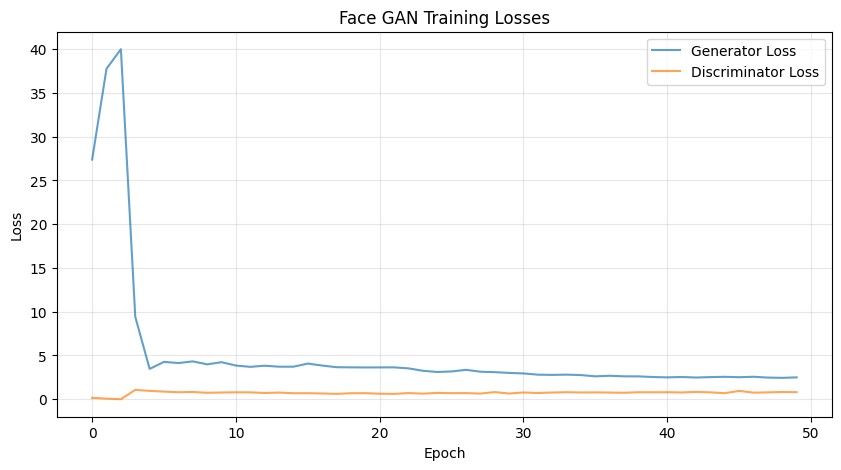

In [9]:
# 学習損失をグラフで表示
def plot_losses():
    plt.figure(figsize=(10, 5))
    plt.plot(G_losses, label='Generator Loss', alpha=0.7)
    plt.plot(D_losses, label='Discriminator Loss', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Face GAN Training Losses')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_losses()

## 実画像と生成画像の比較

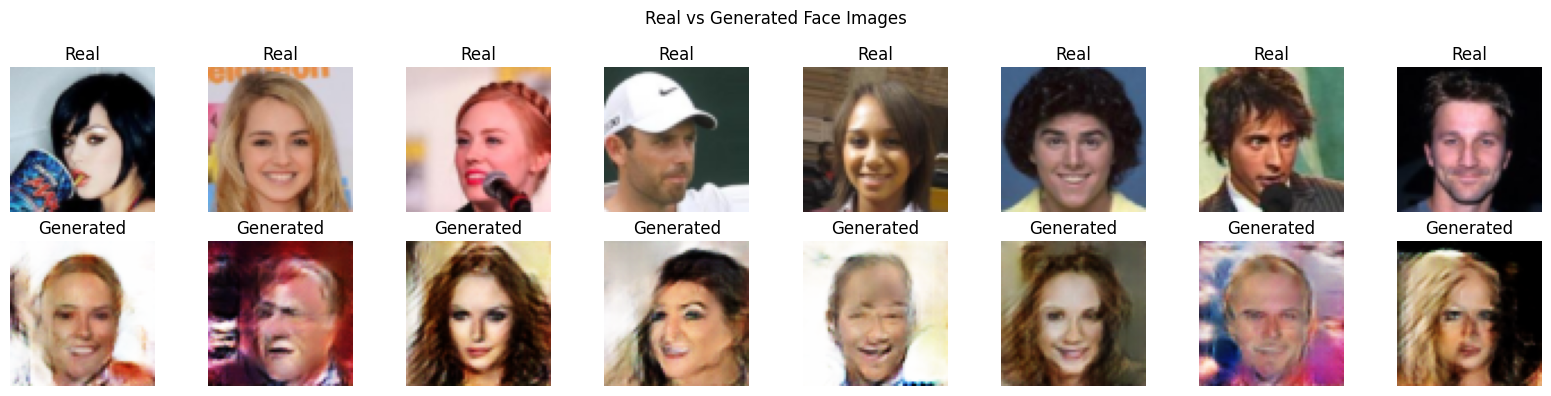

In [10]:
# 画像品質の比較表示
def compare_real_vs_generated():
    # 実画像の取得
    real_batch = next(iter(dataloader))
    real_images = real_batch[0][:8].to(device)
    real_images = (real_images + 1) / 2

    # 生成画像の作成
    netG.eval()
    with torch.no_grad():
        noise = torch.randn(8, nz, 1, 1, device=device)
        fake_images = netG(noise)
        fake_images = (fake_images + 1) / 2
    netG.train()

    # 比較表示
    fig, axes = plt.subplots(2, 8, figsize=(16, 4))

    # 実画像
    for i in range(8):
        img = real_images[i].permute(1, 2, 0).cpu().numpy()
        axes[0, i].imshow(img)
        axes[0, i].set_title('Real')
        axes[0, i].axis('off')

    # 生成画像
    for i in range(8):
        img = fake_images[i].permute(1, 2, 0).cpu().numpy()
        axes[1, i].imshow(img)
        axes[1, i].set_title('Generated')
        axes[1, i].axis('off')

    plt.suptitle('Real vs Generated Face Images')
    plt.tight_layout()
    plt.show()

compare_real_vs_generated()

## ノイズベクトルの補間による顔の変化を観察


5. 顔の補間実験:


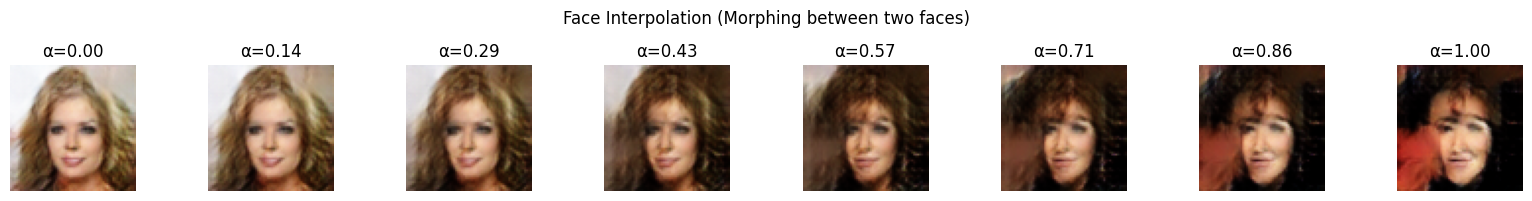

In [11]:
# 顔の特徴変化実験
def face_interpolation():
    netG.eval()

    # 2つの異なるノイズベクトル
    noise1 = torch.randn(1, nz, 1, 1, device=device)
    noise2 = torch.randn(1, nz, 1, 1, device=device)

    # 補間の重み
    alphas = torch.linspace(0, 1, 8)
    interpolated_images = []

    with torch.no_grad():
        for alpha in alphas:
            # 線形補間
            interpolated_noise = (1 - alpha) * noise1 + alpha * noise2
            generated = netG(interpolated_noise)
            generated = (generated + 1) / 2
            interpolated_images.append(generated[0])

    # 結果表示
    fig, axes = plt.subplots(1, 8, figsize=(16, 2))
    for i, img in enumerate(interpolated_images):
        img_np = img.permute(1, 2, 0).cpu().numpy()
        axes[i].imshow(img_np)
        axes[i].set_title(f'α={alphas[i]:.2f}')
        axes[i].axis('off')

    plt.suptitle('Face Interpolation (Morphing between two faces)')
    plt.tight_layout()
    plt.show()

    netG.train()

face_interpolation()

In [12]:
# モデルの保存
torch.save(netG.state_dict(), 'face_generator.pth')
torch.save(netD.state_dict(), 'face_discriminator.pth')